In [1]:
%matplotlib inline
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import decomposition
from sklearn import neighbors
from sklearn import impute
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline
from sklearn import compose

# Create a class to create pandas dataframe from SQL queries

In [3]:
#Read data from JDBC server
class DB:
    def __init__(self):
        self.tables = None
        self.df = None
        self.point = None
        self.POSTGRES_HOST = "codd03.research.northwestern.edu"
        self.POSTGRES_PORT = 5432
        self.POSTGRES_DBNAME = 'cpdb'
        self.POSTGRES_USERNAME = 'cpdb_student'
        self.POSTGRES_PASSWORD = 'DataSci4Lyfe'
        self.postgres_str = ('postgresql://{username}:{password}@{host}:{port}/{dbname}'.format(username=self.POSTGRES_USERNAME,
                                                                                           password=self.POSTGRES_PASSWORD,
                                                                                           host=self.POSTGRES_HOST,
                                                                                           port=self.POSTGRES_PORT,
                                                                                           dbname=self.POSTGRES_DBNAME))
        self.engine = create_engine(self.postgres_str)

    def query(self, queryCommand):
            self.point = self.engine.execute(queryCommand)
            self.df = None
            try: self.df = pd.DataFrame([*self.point.mappings()])
            except Exception as msg:
                if msg == 'This result object does not return rows. It has been closed automatically.':pass
            return self.df

    def get_tables_from_commands(self, commands=None):
        self.tables = {}
        for command in commands:
            try:
                df = self.query(command)
                if df is not None:
                    self.tables[f't{len(self.tables.keys())}'] = {'frame': df, 'sql': command}
            except:
                pass
        return self.tables

def table_from_file(filename):
    obj = DB()
    t = obj.get_tables_from_commands
    with open(filename, 'r') as f:
        sqlFile = f.read()
    commands_raw = sqlFile.split(';')
    commands = []
    for command in commands_raw:
        q = f'''
        {command}
        '''
        commands.append(q)
    tables = t(commands)
    total = len(tables.keys())
    print(total, "tables received")
    del obj
    return (total, tables)

<br>

### Encoding/Decoding/cleaning helpers


In [4]:
def convert():
    # convert beats to sides
    filename = 'console0.sql'
    _, table = table_from_file(filename)

    # a dictionary that helps categorize beats to north or south
    temp_dict = table['t0']['frame'].to_dict('records')
    conversion_dict = {}
    for t in temp_dict:
        if t['name'] not in conversion_dict.keys():
            conversion_dict[t['name']] = t['side']
    return conversion_dict

conversion_dict = convert()

1 tables received


In [5]:
def kneighbours(beats):
    samples = list(conversion_dict.keys())
    neigh = neighbors.NearestNeighbors(n_neighbors=1)
    neigh.fit(np.reshape(np.array(samples), (-1, 1)))

    beats = np.reshape(np.array(list(beats)), (-1, 1))
    sample_idx = neigh.kneighbors(beats, return_distance=False)

    beatsNew = [ samples[i[0]] for i in sample_idx ]
    return beatsNew


### Preprocessing helpers

In [6]:
# keep columns which have more than 85% missing values
def remove_missing(data):
    columns = list(data.columns)
    print(f"Originallly {len(columns)} columns")
    missing = pd.DataFrame(data.isnull().sum())
    missing.reset_index(inplace=True)
    missing = missing.rename(columns = {'index':'columns', 0: 'null count'})
    missing["null count"] = missing["null count"].apply(lambda x: x*100/len(df1))
    remaining_columns = missing[missing["null count"] < 85.0]["columns"]
    print(f"Dropped to {len(remaining_columns)} columns by 85% rule")
    print(list(remaining_columns))
    return list(remaining_columns)

In [7]:
# imputation
zeroImputer = impute.SimpleImputer(strategy='constant', fill_value=0)
meanImputer = impute.SimpleImputer()

imputers = [('zero', zeroImputer), ('mean', meanImputer)]

In [8]:
# scaling
scalerST = preprocessing.StandardScaler()
scalerRB = preprocessing.RobustScaler()
scalers = [('std', scalerST), ('rb', scalerRB)]

### Feature Selection helpers

In [9]:
incrPCA = decomposition.IncrementalPCA()

### model selection helpers

In [10]:
# linear models

regrLinear = linear_model.LinearRegression()
regrRidge = linear_model.Ridge()
regrGamma = linear_model.GammaRegressor()
regrSGD = linear_model.SGDRegressor()



In [11]:
# kernal ridge
regrKernal = kernel_ridge.KernelRidge()


In [12]:
# classification

classLog = linear_model.LogisticRegression()

### Data visualization helpers

In [13]:
def plotLine(df, years):
    count = list(df["count"])
    plt.figure(figsize=(10,4))
    plt.plot(years, count)
    plt.xlabel("Year")
    plt.ylabel("trr report count")
    plt.show()

In [14]:
def barNS(df,years, name = "img.jpg"):
    barwidth = 0.3

    # years = df[df["side"]=='north']["years"] # same for south
    countNorth = df[df["side"]=='north']["count"]
    countSouth = df[df["side"]=='south']["count"]

    r1 = np.arange(len(countNorth))
    r2 = [x + barwidth for x in r1]

    fig = plt.subplots(figsize=(12, 3))
    plt.bar(r1, countNorth, width=barwidth, color='r', edgecolor="black", label="north")
    plt.bar(r2, countSouth, width=barwidth, color='g', edgecolor="black", label="south")
    plt.xlabel("year")
    plt.ylabel("trr count")
    plt.xticks([r + barwidth for r in range(len(countNorth))], years)
    plt.legend()
    plt.savefig("images\\"+name)
    plt.show()

def bar_pred_NS(df1, df2, years, name = "img.jpg"):
    barwidth = 0.5

    # years = df[df["side"]=='north']["years"] # same for south
    countNorth1 = df1[df1["side"]=='north']["count"]
    countNorth2 = df2[df2["side"]=='north']["count"]
    countSouth1 = df1[df1["side"]=='south']["count"]
    countSouth2 = df2[df2["side"]=='south']["count"]

    r1 = np.arange(len(countNorth1))
    # print(r1)
    r2 = [x + barwidth for x in r1]
    # print(r2)

    r3 = [x + 2*barwidth for x in r1]
    # print(r3)
    r4 = [x + 3*barwidth for x in r1]
    # print(r4)
    fig = plt.subplots(figsize = (12, 12))
    plt.bar(r1, countNorth1, width=barwidth, color='blue', edgecolor="black", label="north_real")
    plt.bar(r2, countNorth2, width=barwidth, color='green', edgecolor="red", label="north_prediction")
    plt.bar(r3, countSouth1, width=barwidth, color='blue', edgecolor="black", label="south_real")
    plt.bar(r4, countSouth2, width=barwidth, color='green', edgecolor="red", label="south_prediction")
    plt.xlabel("year")
    plt.ylabel("trr count")
    # print([r + 2*barwidth for r in range(len(countNorth1))])
    plt.xticks([r + 2*barwidth for r in range(len(countNorth1))], labels = years, rotation=25)
    plt.legend()
    plt.savefig("images\\"+name)
    plt.show()

<br>

# Get all required tables

# console1.sql

In [15]:
filename = 'console1.sql'
total, tables = table_from_file(filename)

3 tables received


In [16]:
df0 = tables['t0']['frame']
q0 = ' '.join(tables['t0']['sql'].split('\n'))
print(q0)
df0.to_csv('tables\\df0.csv')

          select * from trr_count_by_year_side         


In [17]:
df1 = tables['t1']['frame']
q1 = ' '.join(tables['t1']['sql'].split('\n'))
print(q1)
df1.to_csv('tables\\df1.csv')

          select * from trr_count_by_year         


In [18]:
df2 = tables['t2']['frame']
q2 = ' '.join(tables['t2']['sql'].split('\n'))
print(q2)
df2.to_csv('tables\\df2.csv')

          select * from trr_count_by_year_beats         


In [19]:
df0 = pd.read_csv("tables\\df0.csv").sort_values(by="years")

In [20]:
df1 = pd.read_csv("tables\\df1.csv").sort_values(by="years")

In [21]:
df2 = pd.read_csv("tables\\df2.csv").sort_values(by="years")

In [22]:
years = list(df1["years"])

**What is TRR?**
TRR is the abbreviation for *Tactical Response Reports*. Usually an event has one complaint with a unique id (CRID) linked to it. But in cases when an event has one or more use of force reports linked to it, it comes under TRR data.

Let's check out the trr counts from each year. First we'll look at overall trr count yearly, and then we will visualize the trr count by year distinguished by north and south sides.

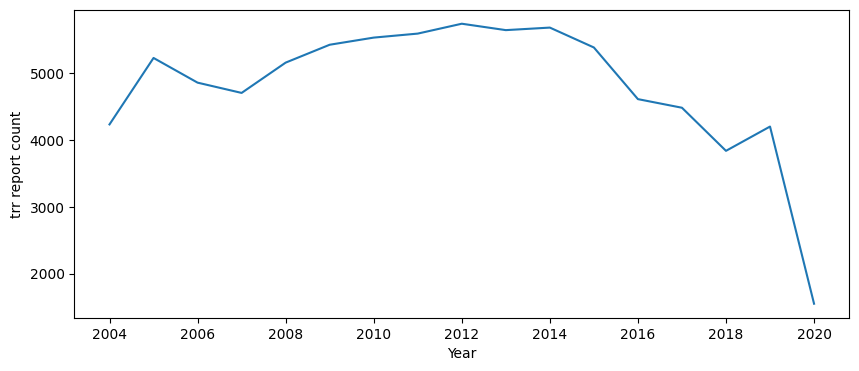

In [23]:
plotLine(df1, years)

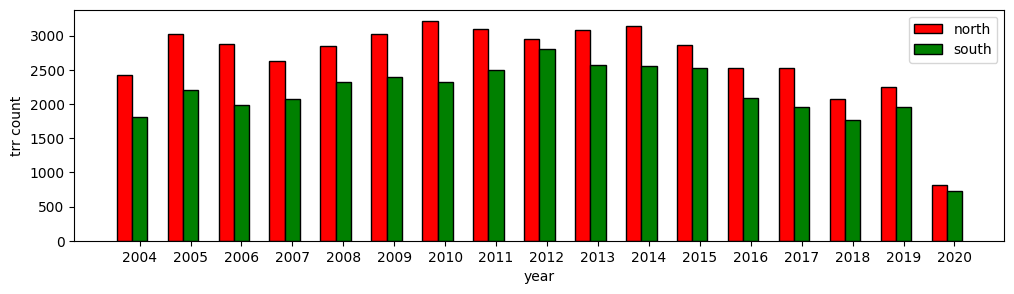

In [24]:
barNS(df0, years, "full_data_d0.jpg")

**Observation:**
It is interesting to note that in all cases multiple cases of complaint reports related to a single event comes usually from the north side. Overall, 2020 has far fewer trr reports. These could be because the data for 2020 is more recent and possibly lacking.

**Question** : *Can we use this information to create a reliable model that can predict the trr count per year?*

 We are going to use df2 for this part, which contains all the beat names and is categorized according to trr count per year per beat. We are going to define our goal first.

### **GOAL** : Predict the yearly trr count by city side.


**Question:** *Why are we using df2?* 

df0 only concerns with two columns : city side and trr count. This is a very small dataset and therefore not reliable enough to train our model. df2 however, is concerned with more detail- the beats. Therefore, this is more reliable to train our model. 

In [25]:
df2 = df2.drop(columns=['Unnamed: 0'])
df2.head(3)

,beat,count,years
0,1923,7,2004
2957,1922,3,2004
2966,211,7,2004


In [26]:
y = np.array(df2["count"])
X = np.array(df2[['beat', 'years']])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=10)
print(len(X_train), '\n', len(X_test))

3540 
 885


Checking out a very simple model first! We are only using standard scaler followed by linear regression

In [27]:
X_tf = scalerST.fit_transform(X_train)
regrLinear.fit(X_tf, y_train)
metrics.r2_score(y_test, regrLinear.predict(X_test))


-144787.3818380805

This simple model performs VERY poorly. Can we improve?

In [30]:
random.seed(10)

pipelines = []
models = [('lreg', regrLinear), ('rreg', regrRidge), ('greg', regrGamma), ('sgdreg', regrSGD), ('kreg', regrKernal)]
results1 = {"model" : [], "best hparams": [], "best score": [], "features": [None]*10}
scaling_union = ('scaler', pipeline.FeatureUnion(scalers))
params = [{'lreg__positive': [True, False]},
          {'rreg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'rreg__positive': [True, False]},
          {'greg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'greg__warm_start': [True, False]},
          {'sgdreg__penalty': ['l2', 'l1', 'elasticnet'], 'sgdreg__learning_rate': ['optimal', 'invscaling', 'adaptive'], 'sgdreg__max_iter': [10000]},
          {'kreg__alpha': [0.00005, 0.0001, 0.0005, 0.001, 0.005], 'kreg__kernel': ["rbf"]}]


for i in range(len(models)):
    results1["model"].append(models[i][1])
    results1["model"].append(models[i][1])
    reg1 = pipeline.Pipeline(steps = [scaling_union, models[i]])
    reg2 = pipeline.Pipeline(steps =
                             [
                                 ('imputation', zeroImputer),
                                 ('beatyear',
                                   compose.ColumnTransformer([('categorical1', preprocessing.OneHotEncoder(), [0, 1])])
                                  ),
                                 models[i]
                             ]
    )
    grids1 = model_selection.GridSearchCV(reg1, param_grid=params[i], cv = 5)
    grids1.fit(X_train, y_train)
    best_estimator1 = grids1.best_estimator_
    score1 = model_selection.cross_val_score(best_estimator1, X_train, y_train, cv=5)
    score2 = model_selection.cross_val_score(reg2, X_train, y_train, cv = 5)
    reg2.fit(X_train, y_train)
    pipelines.append(best_estimator1)
    pipelines.append(reg2)
    best_estimator1.fit(X_train, y_train)
    results1["best score"].append(score1)
    results1["best score"].append(score2)
    results1["best hparams"].append(grids1.best_params_)
    results1["best hparams"].append("No tuning")
    print(i+1, '/', len(models))


resultdf = pd.DataFrame(results1)
print("View of one of the pipelines :")
pipelines[4]

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
View of one of the pipelines :


Pipeline(steps=[('scaler',
                 FeatureUnion(transformer_list=[('std', StandardScaler()),
                                                ('rb', RobustScaler())])),
                ('greg', GammaRegressor(alpha=0.01, warm_start=True))])

In [31]:
len(pipelines)

10

In [32]:
def get_counts(est, X_test, y_test, years):
    y_pred = pd.DataFrame(est.predict(X_test)).rename(columns={0: 'count'})
    y_testdf = pd.DataFrame(y_test).rename(columns = {0: 'count'})

    X_testdf = pd.DataFrame(X_test).rename(columns={0: 'side', 1: 'years'})
    X_testdf["side"] = X_testdf["side"].apply(lambda x: conversion_dict[x])

    df_pred = pd.concat([X_testdf, y_pred], axis=1, join='inner')
    df_actual = pd.concat([X_testdf, y_testdf], axis=1, join='inner')

    temp_pred = df_pred.groupby(['side', 'years']).agg({'count': ['sum']})
    temp_actual = df_actual.groupby(['side', 'years']).agg({'count': ['sum']})

    temp_pred.columns = ['sum']
    temp_actual.columns = ['sum']

    df_pred = temp_pred.reset_index().rename(columns={'sum':'count'})
    df_actual = temp_actual.reset_index().rename(columns={'sum':'count'})
    score = metrics.r2_score(df_pred['count'], df_actual['count'])
    # bar_pred_NS(df_actual, df_pred, f"pipeline_score_{score}.img")
    return (df_pred, df_actual, years, score)

In [33]:
corrected_results = []
df_pred, df_actual = None, None
for i in range(len(pipelines)):
    df_pred, df_actual, years, score = get_counts(pipelines[i], X_test, y_test, years)
    corrected_results.append(score)
resultdf['best score'] = corrected_results
resultdf['features'] = ["beat, side"]*10
resultdf.to_csv("results\\result1.csv")
resultdf

,model,best hparams,best score,features
0,LinearRegression(),{'lreg__positive': False},-0.375190,"beat, side"
1,LinearRegression(),No tuning,0.864049,"beat, side"
2,Ridge(),"{'rreg__alpha': 1, 'rreg__positive': False}",-0.545053,"beat, side"
3,Ridge(),No tuning,0.866203,"beat, side"
4,GammaRegressor(),"{'greg__alpha': 0.01, 'greg__warm_start': True}",-0.464664,"beat, side"
5,GammaRegressor(),No tuning,-0.958244,"beat, side"
6,SGDRegressor(),"{'sgdreg__learning_rate': 'adaptive', 'sgdreg_...",-0.545057,"beat, side"
7,SGDRegressor(),No tuning,0.865491,"beat, side"
8,KernelRidge(),"{'kreg__alpha': 5e-05, 'kreg__kernel': 'rbf'}",0.604244,"beat, side"
9,KernelRidge(),No tuning,0.867269,"beat, side"


Predicted trr report counts per year for beats included in test data using Kernal Ridge


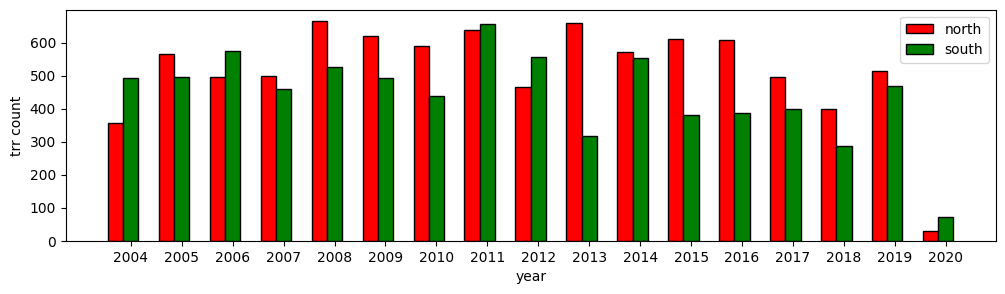

In [36]:
print("Predicted trr report counts per year for beats included in test data using Kernal Ridge")
barNS(df_pred, years, "predicted")

Actual trr counts per year for beats included in test data


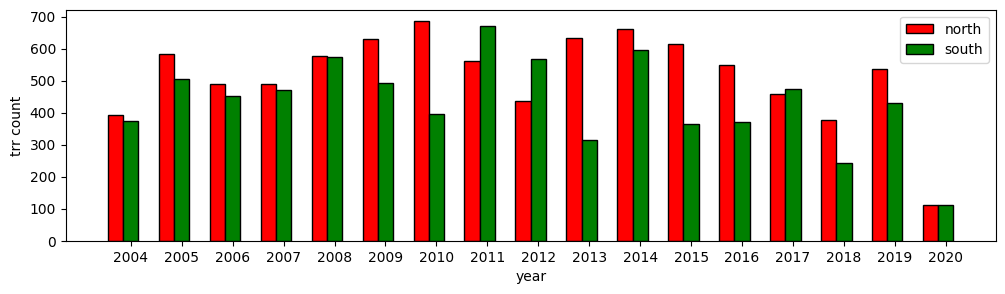

In [37]:
print("Actual trr counts per year for beats included in test data")
barNS(df_actual, years)

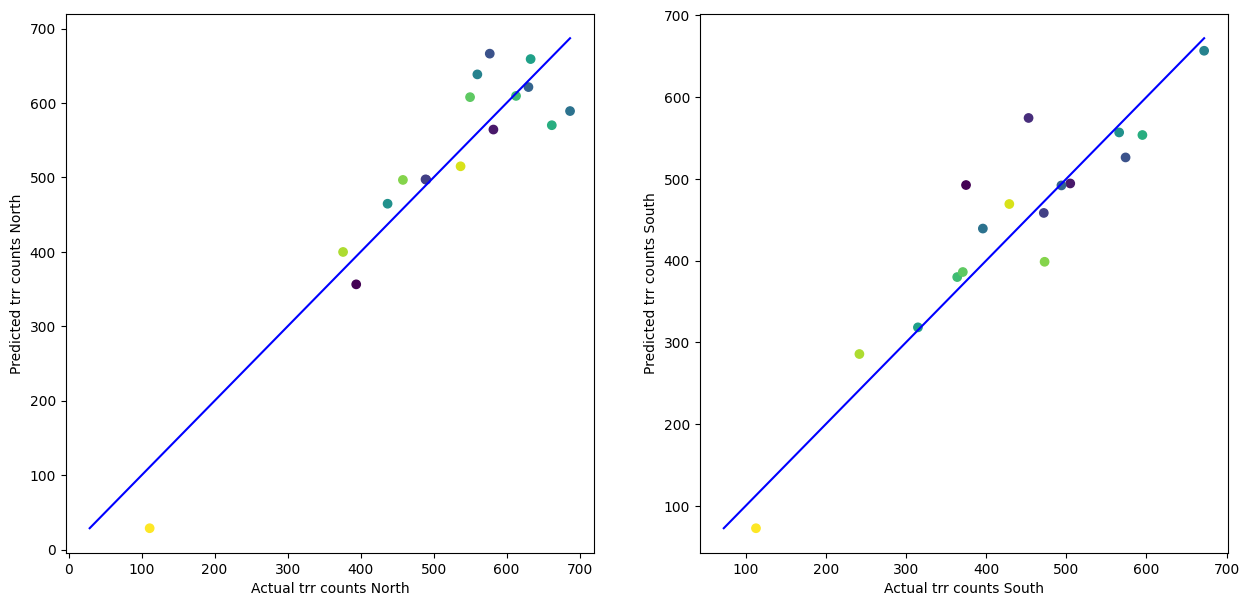

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
# plt.figure(figsize=(10,3))
ax1.scatter(df_actual[df_actual['side']=='north']['count'], df_pred[df_pred['side']=='north']['count'], c=years)
p1 = max(max(df_actual[df_actual['side']=='north']['count']), max(df_pred[df_pred['side']=='north']['count']))
p2 = min(min(df_actual[df_actual['side']=='north']['count']), min(df_pred[df_pred['side']=='north']['count']))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set_xlabel('Actual trr counts North', fontsize=10)
ax1.set_ylabel('Predicted trr counts North', fontsize=10)

ax2.scatter(df_actual[df_actual['side']=='south']['count'], df_pred[df_pred['side']=='south']['count'], c=years)
p1 = max(max(df_actual[df_actual['side']=='south']['count']), max(df_pred[df_pred['side']=='south']['count']))
p2 = min(min(df_actual[df_actual['side']=='south']['count']), min(df_pred[df_pred['side']=='south']['count']))
ax2.plot([p1, p2], [p1, p2], 'b-')
ax2.set_xlabel('Actual trr counts South', fontsize=10)
ax2.set_ylabel('Predicted trr counts South', fontsize=10)
plt.show()

<br>

### Question

How can we improve now?

Let us use a bit more information, such as the officer info. We are going to now perform a few more sql queries for that.

In [169]:
filename = 'console2.sql'
_, tables = table_from_file(filename)

1 tables received


In [170]:
''.join(tables['t0']['sql'].split('\n'))

'        select * from officer_trr        '

In [171]:
df3 = tables['t0']['frame']
df3.to_csv("tables\\df3.csv")

In [186]:
df3 = pd.read_csv('tables\\df3.csv', low_memory = False).drop(columns = 'Unnamed: 0')

In [187]:
df3.head(2)

,active,allegation_count,appointed_date,beat,birth_year,civilian_allegation_percentile,civilian_compliment_count,complaint_percentile,current_badge,current_salary,...,race,rank,resignation_date,suffix_name,sustained_count,tags,trr_count,trr_percentile,unsustained_count,years
0,Yes,22.0,1994-07-05,1651,1969.0,65.6966,4.0,81.8922,7381.0,93354.0,...,Black,Police Officer,NaN,NaN,2.0,[],3.0,56.6663,15.0,2016
1,Unknown,0.0,2017-07-17,1135,1985.0,NaN,0.0,NaN,7970.0,48078.0,...,White,Police Officer,NaN,NaN,0.0,[],0.0,NaN,0.0,2018


In [188]:
df3 = df3.drop(columns=['appointed_date', 'id'])



# if 85% missing, drop column
columns_remaining = remove_missing(df3)
df3 = df3[columns_remaining]

# tags is only empty list therefore, drop
df3 = df3.drop(columns = 'tags')

Originallly 30 columns
Dropped to 10 columns by 85% rule
['active', 'beat', 'birth_year', 'current_badge', 'first_name', 'gender', 'last_name', 'race', 'tags', 'years']


### Cleaning

In [189]:
# some of the beats in trr_trr are incorrect and are not represented in the data_area. We could either drop the rows with beats or use Nearest neighbours to fill them with the most likely beat in data_area.

beats = df3['beat']
df3['beat'] = kneighbours(beats)

# adding a side column using the converter
df3["side"] = df3["beat"].apply(lambda x: conversion_dict[x])
df3_north, df3_south = df3[df3['side'] == 'north'], df3[df3['side'] == 'south']

# convert to numpy array for further computations
dataset3 = df3.to_dict('split')
data3 = np.array(dataset3['data'], dtype = 'object')
print("ndarray shape: ", data3.shape)


ndarray shape:  (83781, 10)


We saw earlier when we modelled our question after a regression problem one of the biggest caviats was that our model predicted "counts" as a float entity. But counts should be strictly integer. There might be work around for that, but an easier solution would be to take a classification route with an attribute that has smaller domain than *counts*. So this time we will try to use the "years" column as our classification target. We would have 17 distinct target labels in this case. Once we predict the year, we can count the number of trr incidents predicted for a particular year.

In [192]:
# data and target
years_idx = dataset3['columns'].index('years')
cols_idx = list(np.arange(len(dataset3['columns'])))
cols_idx.remove(years_idx)

X, y = np.array(data3[:, cols_idx]), np.array(data3[:, years_idx])
print("Data and target shape: ", X.shape, y.shape)
X_ = zeroImputer.fit_transform(X)
y_ = zeroImputer.fit_transform(y.reshape(-1,1))
y_ = list(y_.reshape(1,-1)[0])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_, y_, test_size=0.20, random_state=0)
print("Train and test data shape:", X_train.shape, X_test.shape)
print("Train and test target length", len(y_train), len(y_test))

# birth year to integer
by_col = dataset3['columns'].index('birth_year')
bdg_num = dataset3['columns'].index('current_badge')
X_train[:, [by_col, bdg_num]] = X_train[:, [by_col, bdg_num]].astype(int)
X_test[:, [by_col, bdg_num]] = X_test[:, [by_col, bdg_num]].astype(int)

Data and target shape:  (83781, 9) (83781,)
Train and test data shape: (67024, 9) (16757, 9)
Train and test target length 67024 16757


### Baseline

In [197]:
# column transform
col_transformers = compose.ColumnTransformer([
    ('ordinal1', preprocessing.OrdinalEncoder(), [dataset3['columns'].index('active'), dataset3['columns'].index('gender'), dataset3['columns'].index('race'), -1]),
    ('ordinal2', preprocessing.OrdinalEncoder(), [dataset3['columns'].index('beat'), dataset3['columns'].index('birth_year')]),
    ('text1', feature_extraction.text.CountVectorizer(), dataset3['columns'].index('first_name')),
    ('text2', feature_extraction.text.CountVectorizer(), dataset3['columns'].index('last_name'))
])

X_train_ = col_transformers.fit_transform(X_train)
X_test_ = col_transformers.transform(X_test)
print('done')

done


In [198]:
from sklearn.naive_bayes import MultinomialNB
multinb = MultinomialNB()
multinb.fit(X_train_, y_train)


MultinomialNB()

In [199]:
y_pred = multinb.predict(X_test_)
metrics.accuracy_score(y_pred, y_test)

0.10079369815599451

In [204]:
columns = dataset3['columns'].copy()
columns.remove('years')
xdf = pd.DataFrame(X_train)
ydf = pd.DataFrame(y_train).rename(columns={0: 'years'})
ypreddf = pd.DataFrame(y_pred).rename(columns = {0: 'years'})
test_df = pd.concat([xdf, ydf ], axis=1, join='inner')
pred_df = pd.concat([xdf, ypreddf ], axis=1, join='inner')

for i in range(len(columns)):
    test_df = test_df.rename(columns={i: columns[i]})
    pred_df = pred_df.rename(columns={i: columns[i]})
pred_df.head(3)

,active,beat,birth_year,current_badge,first_name,gender,last_name,race,side,years
0,No,1134,1959,7276,Donald,M,Banks,Black,north,2013
1,No,1024,1961,8827,Anthony,M,Giella,White,north,2008
2,Yes,132,1983,12468,Gaspar,M,Castro,Hispanic,south,2004


In [205]:
test_df.head(3)

,active,beat,birth_year,current_badge,first_name,gender,last_name,race,side,years
0,No,1134,1959,7276,Donald,M,Banks,Black,north,2014
1,No,1024,1961,8827,Anthony,M,Giella,White,north,2004
2,Yes,132,1983,12468,Gaspar,M,Castro,Hispanic,south,2009


In [206]:
columns

['active',
 'beat',
 'birth_year',
 'current_badge',
 'first_name',
 'gender',
 'last_name',
 'race',
 'side']

In [251]:
test_df_ = test_df[['side', 'years']]
pred_df_ = pred_df[['side', 'years']]
count_test = test_df_.groupby(['side', 'years']).size().reset_index(name='count')
count_pred = pred_df_.groupby(['side', 'years']).size().reset_index(name='count')

In [252]:
count_test

,side,years,count
0,north,2004,2165
1,north,2005,2691
2,north,2006,2471
3,north,2007,2302
4,north,2008,2473
5,north,2009,2623
6,north,2010,2797
7,north,2011,2638
8,north,2012,2383
9,north,2013,2414


In [253]:
count_pred

,side,years,count
0,north,2004,322
1,north,2005,2168
2,north,2006,497
3,north,2007,128
4,north,2008,240
5,north,2009,397
6,north,2010,590
7,north,2011,322
8,north,2012,300
9,north,2013,254


In [255]:
metrics.r2_score(count_test['count'], count_pred['count'])

-9.669971014639108

## Now applying this in a pipeline and doing finetuning

In [ ]:
imputing_union = pipeline.FeatureUnion(imputers)
col_transformers = compose.ColumnTransformer([
    ('ordinal1', preprocessing.OrdinalEncoder(), [dataset3['columns'].index('active'), dataset3['columns'].index('gender'), dataset3['columns'].index('race'), -1]),
    ('ordinal2', preprocessing.OrdinalEncoder(), [dataset3['columns'].index('beat'), dataset3['columns'].index('birth_year')]),
    ('text1', feature_extraction.text.CountVectorizer(), dataset3['columns'].index('first_name')),
    ('text2', feature_extraction.text.CountVectorizer(), dataset3['columns'].index('last_name'))
])
incrPCA
